# Finite Volume Advection Equation
Solving $u_t+au_x = 0 $ using finite volumes with options for:
- first order upwind
- second order central upwind
- third order upwind
- flux limiting


In [1]:
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
from scipy import stats

In [93]:
def first_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if j < J:
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def second_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            flux_right = (min(c,0)*(U[n, j+1] + 0.5*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] + 0.5*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def third_order_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return 1/3 + (1/6)*theta
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def flux_limited_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])

        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right) 

    return U

def solve_adv_eqn(solver=first_order_upwind, a=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=0.2))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol = solver(U, c, n, J)
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol

ZeroDivisionError: division by zero

first_order_upwind mass loss was 0.00000%
third_order_upwind mass loss was 4818643729880361164171506378591578530928941066145272050988284427411272514315162463648113229824.00000%
flux_limited_upwind mass loss was 0.00000%


C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


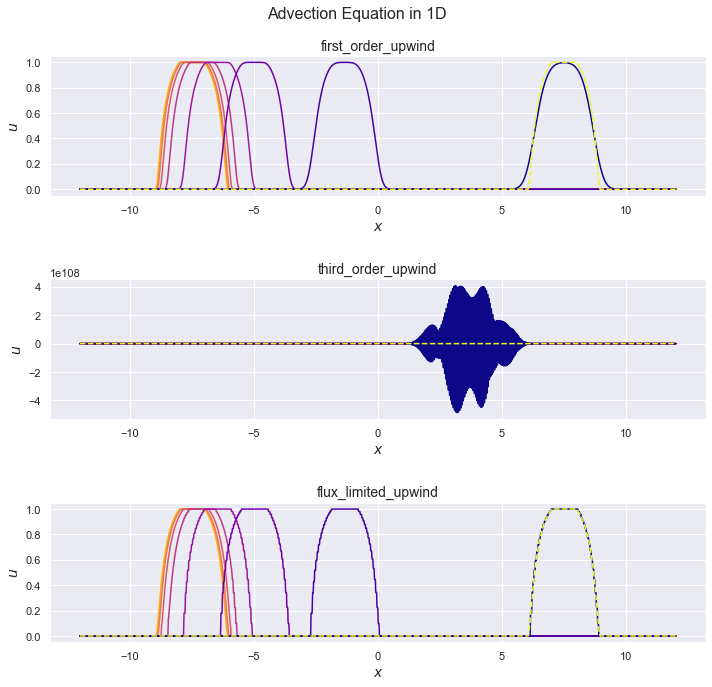

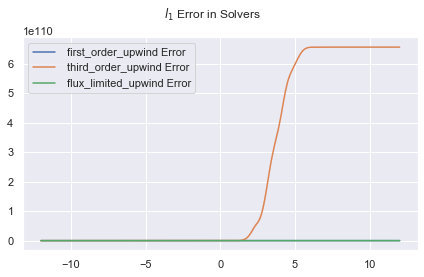

In [94]:
colormap = plt.get_cmap('plasma')
adv_solvers = [first_order_upwind, third_order_upwind, flux_limited_upwind]

def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=-1, scale=1)
def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+1:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp(1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1
        else:
            f[i] = 0
    return f

initial_data = (lambda x: bump(x+7.5,0.5)) #(lambda x: bump(x+7,0.5))
wavespeed = 1
T_final = 15

fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection Equation in 1D', fontsize=16)
err_fig, err_ax= plt.subplots()
if len(adv_solvers)==1:
    ax = [ax]

for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_eqn(solver=solver, a=wavespeed, T_end=T_final, dx=0.01,
                                   dt=0.005, L=12,initial_dist=initial_data)
    ax[idx].set_title(solver.__name__, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
    ax[idx].plot(adv_x, initial_data(adv_x-wavespeed*T_final), ls='--')
    true_sol = initial_data(adv_x-wavespeed*T_final)
    err_ax.plot(adv_x, np.cumsum(abs(true_sol - adv_sol[-1,])), label=' {} Error'.format(solver.__name__))
    err_ax.legend()

err_fig.suptitle(r'$l_1$ Error in Solvers')
err_fig.show()    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.6)
fig.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
savepath = './'
fig.savefig(savepath+'{}.jpg'.format('bump_test'), format='jpg', dpi=1000)
err_fig.savefig(savepath+'{}.jpg'.format('bump_test_error'), format='jpg', dpi=1000)
fig.show()


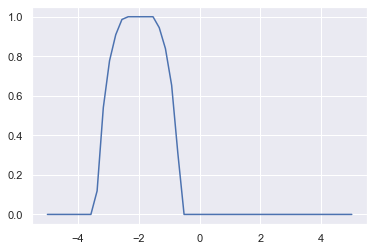

In [48]:
def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+1:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp( 1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1
        else:
            f[i] = 0
    return f
x = np.linspace(-5,5)
plt.plot(x,bump(x+2,0.5))
plt.show()

# Advection-Diffusion Equation
Add in a diffusive term, $\sigma \frac{\mathrm{d}^2 u}{\mathrm{d}x^2}$. Solve using Crank-Nicolson

In [62]:
def first_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]


    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if j < J:
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
                
        else:
            flux_right = 0

        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def second_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]

    for j in range(J+1):
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            flux_right = (min(c,0)*(U[n, j+1] + 0.5*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] + 0.5*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
            
        elif j==1 or j==J-1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
            
        else:
            flux_right = 0

        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def third_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx) 
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]

    eps = 10**-8
    def psi(theta): return 1/3 + (1/6)*theta
    for j in range(J+1):  
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
    
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])    
        else:
            flux_right = 0
            
        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def flux_limited_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]
    
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])  
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1]) 
            
        else:
            flux_right = 0
        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U


def solve_adv_eqn(solver=first_order_upwind, a=1, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol = solver(U, a, D, dt, dx, n, J)
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol

first_order_upwind mass loss was 0.01012%
second_order_upwind mass loss was 0.00716%
third_order_upwind mass loss was 0.00705%
flux_limited_upwind mass loss was 0.00705%


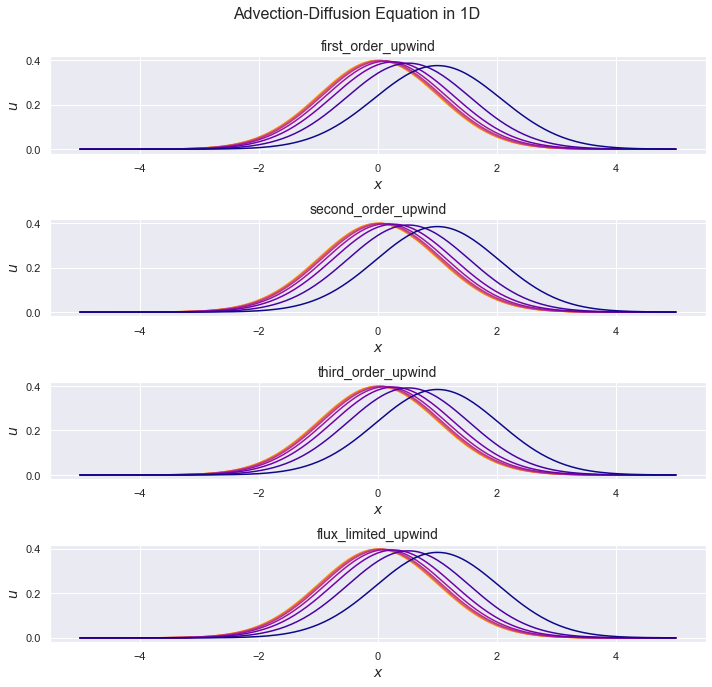

In [63]:
colormap = plt.get_cmap('plasma')
adv_solvers = [first_order_upwind, second_order_upwind, third_order_upwind, flux_limited_upwind]
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection-Diffusion Equation in 1D', fontsize=16)

def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])

for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_eqn(solver=solver, a=0.25, D=0.01, T_end=4, dx=0.05, dt=0.01)
    ax[idx].set_title(solver.__name__, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
savepath = './'
plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()

## 2D Diffusion


In [ ]:
def FTCS(U, mu, N, J):
    """

    """
    if mu >= 0.5:
        warnings.warn('Method is likely to be unstable, mu>1/2')

    for n in range(N): #0,...,N-1
        for j in range(J+1): #0,..., J
            if j==0 or j==J:
                U[n, j] = 0 # Set BC
                continue
            U[n+1, j] = U[n,j] + mu*(U[n, j+1] - 2*U[n, j] + U[n, j-1])
    return U

def CN(U, mu, N, J):
    a = 0.5 * mu
    b = 1 + mu
    c = 0.5 * mu

    d = np.zeros(J+1)
    e = np.zeros(J+1)
    f = np.zeros(J+1)

    # Build arrays of new coefficients
    for n in range(N):
        for j in range(J+1):
            if j==0 or j==J:
                continue
            d[j] = U[n, j] + 0.5* mu * (U[n, j+1] - 2*U[n, j] + U[n, j-1])
            e[j] = c/(b - a*e[j-1])
            f[j] = (d[j] + a*f[j-1]) / (b - a*e[j-1])

        for j in range(J-1, 0, -1):
            U[n+1, j] = f[j] + e[j]*U[n+1, j+1]

    return U

def solve_2d_heat_eqn(solver=FTCS, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
            initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x)  #Initial Conditions
    U[0,] = U_0

    mu = D*dt/(dx**2)

    sol = solver(U, mu, N, J)

    return x, sol


### Which solver does it prefer where?

In [108]:
def flux_limited_upwind(U, c, n, J, psi_hist):
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            print(theta)
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            psi_hist[j] = psi(theta)
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])

        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right) 

    return U, psi_hist

def solve_adv_eqn(solver=first_order_upwind, a=1, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    psi_hist=np.zeros(J+1)
    psi_total=np.zeros((N+1,J+1), dtype=float)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol, psi_hist = solver(U, c, n, J, psi_hist)
        psi_total[n,:] = psi_hist
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol, psi_total

In [109]:
colormap = plt.get_cmap('plasma')
fig, ax = plt.subplots(2,1, figsize=(20,10))
fig.suptitle('Advection Equation in 1D', fontsize=16)

def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])
initial_data = (lambda x: bump(x+7.5,1.5)) 
#initial_data = block
initial_data =  lambda x: stats.norm.pdf(x, loc=-6, scale=1)
adv_x, adv_sol, psi_total = solve_adv_eqn(solver=flux_limited_upwind, initial_dist=initial_data, a=1, T_end=15, dx=0.1,dt=0.01, L=15)
ax[0].set_title('flux_limited_upwind', fontsize=14)
ax[0].set_xlabel(r'$x$', fontsize=14)
ax[0].set_ylabel(r'$u$', fontsize=14)
ax[0].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
    ax[0].plot(adv_x, adv_sol[int(i),])
fig.show()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.heatmap(psi_total, ax=ax[1])
fig.show()

3.579952349558314e-10
8.527205428298592e-10
2.0106663816289147e-09
4.693272832206706e-09
1.0844579478403863e-08
2.4805577582748644e-08
5.6167386058562336e-08
1.2589711766157753e-07
2.793459966403432e-07
6.135676945455623e-07
1.3340558337959027e-06
2.8712755217680894e-06
6.11733760585798e-06
1.2901292940793343e-05
2.6932831933563257e-05
5.565450549107948e-05
0.00011383437247226884
0.00023044887690805587
0.0004616943639400218
0.0009152122182570881
0.0017943484075018895
0.0034769477386986315
0.006650158489166444
0.012525818798373955
0.02314139757160049
0.04165998547871708
0.07233888517603003
0.1194623375200391
0.1846064669349344
0.26335590975511924
0.34523812899784667
0.41885407482431747
0.4776443088818616
0.5210374056912639
0.5519043915565325
0.5738722683877024
0.5899892858611613
0.60242608990959
0.6126072957671082
0.6214301392248056
0.6294488005715281
0.637003163441753
0.6443017900960523
0.6514733883284033
0.6585981768682106
0.6657268743843034
0.6728921919657752
0.6801158130708258
0.687

7.879907501499384e-05
0.00016010948652825212
0.0003219628837204905
0.0006406110851129627
0.001260699724769715
0.002452140532087476
0.004708017551575756
0.008902717299038
0.016519299323667115
0.029904522893178888
0.052380401067267705
0.08783819347017408
0.13933772730124522
0.20670454120940598
0.28436035680313776
0.3518702886689269
0.4358074419320654
0.4946113370653824
0.5305836068718186
0.5584189128573225
0.5785690402632045
0.5935113568819158
0.605221216417481
0.6149645729516326
0.6235299525235546
0.6314024178297875
0.6388790396345932
0.6461421774403914
0.6533045679785903
0.6604366915071769
0.6675833132982201
0.6747734939677552
0.682026674698443
0.6893564019753372
0.6967726283048866
0.7042831502409959
0.711894521646446
0.7196126469630252
0.7274431796669898
0.7353918033425592
0.7434644441023682
0.7516674458518429
0.7600077296593403
0.7684929526125639
0.7771316784674671
0.7859335712495981
0.7949096232962557
0.8040724308674843
0.8134365334744278
0.8230188377666452
0.8328391537449364
0.8429

0.24387655712328593
0.31353192014590314
0.3818429771106496
0.4725440431452782
0.5138227317112657
0.5449997553347888
0.5687595274292859
0.5861356167455145
0.5993343375585432
0.6099780416389109
0.6190825297101813
0.6272729275959918
0.6349322719096393
0.6422951389120327
0.6495058756943662
0.6566541252586158
0.6637963093659457
0.6709686063482959
0.6781948156324209
0.6854911514598012
0.6928691883263011
0.7003376896147566
0.7079037584621963
0.7155735758475391
0.7233528870577839
0.7312473355435298
0.7392627058583
0.7474051149479325
0.7556811776432438
0.7640981643396203
0.7726641644778859
0.7813882673881537
0.7902807716731519
0.7993534352888282
0.8086197807832236
0.8180954739570406
0.8277987999269599
0.8377512689309526
0.8479783963855968
0.8585107195566584
0.8693851397282144
0.8806467188220437
0.8923511211170414
0.9045679878113949
0.917385688728041
0.930918154884076
0.9453149389183364
0.960776434636088
0.9775776308721175
0.9961065585821939
1.0169292535142072
1.0409053410255764
1.06940710342151

0.6528623270575219
0.6600095597198213
0.667170233095139
0.6743737560043367
0.6816397777329772
0.6889819702447357
0.6964103624091494
0.7039327977350819
0.7115558593220099
0.7192854701231098
0.7271272956195228
0.7350870274612333
0.7431705974643487
0.751384353853748
0.759735221247216
0.7682308599028818
0.7768798366217373
0.7856918185178642
0.7946778011770885
0.8038503843524935
0.8132241113583603
0.8228158930126621
0.83264554390088
0.8427364688148957
0.8531165519409034
0.8638193230894919
0.8748855077880017
0.8863651176490716
0.8983203146073144
0.9108294055151595
0.9239925243989905
0.9379398974164955
0.9528441724611341
0.9689393539004792
0.9865508755308701
1.006145286188405
1.0284162991430588
1.0544425261199815
1.0859953151197068
1.1262933523158019
1.1799477156082385
1.2802597245528051
1.3090945283674502
2.2242710679788016
-44.5991717569922
0.049644788247913234
0.27195659095239727
0.6127160711012672
0.7863983883892998
0.8326151073779303
0.8723902681235383
0.9081389925184729
0.93784601670164

0.7554030018036161
0.7638305147241733
0.7724068732728158
0.7811411698888671
0.7900437063894454
0.7991262441489161
0.8084023094117958
0.8178875720129379
0.8276003214933906
0.8375620729564343
0.8477983471782106
0.8583396873388756
0.8692230012646147
0.8804933581396273
0.8922064303482248
0.9044318682062013
0.9172580519083701
0.9307989244573042
0.9452040526446858
0.9606738474721539
0.9774833196184008
0.9960205288650218
1.0168515119161894
1.0408371818738231
1.0693262966986474
1.1049863809087639
1.1486567731770636
1.236053442064219
1.2590406265586547
1.5516552090100901
6.970621551502513
-1.6103088663652145
0.1666992219717382
0.3982601400700505
0.7296437138413812
0.8168642100244872
0.8545728511197198
0.890946584800586
0.9235394151198502
0.950950685011024
0.9746817261898243
0.9959914254682468
1.0155832571251497
1.033899150166401
1.051251309942135
1.0678669077748635
1.0839140675435397
1.0995198881637651
1.1147823804192718
1.1297784272653981
1.1445692597832475
1.1592043170402027
1.173724019543153

0.8981797955731715
0.910697423357746
0.9238689958228088
0.9378247521643996
0.9527373558686656
0.9688408298226456
0.9864606563300967
1.006062953761423
1.0283484379585808
1.0543136762165328
1.086497330909488
1.1225750368717646
1.1971574369056095
1.234117655575342
1.3265849091584807
2.6359055614045093
-24.739952019349648
0.08911882159166339
0.24949451889360105
0.5630033123307415
0.7914360366966379
0.8406916508412381
0.873768945249146
0.9077675269817966
0.9377302641777651
0.9632147352551991
0.9856353156861699
1.006017989677359
1.0249302266639784
1.0427372013134386
1.0597029121237143
1.0760223670127915
1.0918414836993615
1.1072716421068722
1.122399490850565
1.1372935404399152
1.152008744824629
1.1665897649534653
1.1810733354387646
1.1954900089797897
1.209865461861686
1.2242214848139663
1.238576745110149
1.252947380409476
1.2673474678151966
1.2817894001231849
1.2962841935248826
1.3108417460636121
1.3254710633530415
1.3401804672530837
1.3549778045269887
1.3698706765704922
1.384866719327115
1.

-5.813896889729063e-47
-1.2583708095519474e-47
-2.6983232402924116e-48
-5.7322399963478e-49
-1.2064263673096385e-49
-2.5155000993048687e-50
-5.196320217142458e-51
-1.0634485795773057e-51
-2.1561901974554582e-52
-4.331203296108612e-53
-8.619497240244239e-54
-1.6994488080474862e-54
-3.3196166470987025e-55
-6.42424908167975e-56
-1.231720817826908e-56
-2.3396911658179565e-57
-4.403134872624882e-58
-8.209628126099521e-59
-1.5165050320508861e-59
-2.775389350417669e-60
-5.0322762594806585e-61
-9.039956040261704e-62
-1.608904353042833e-62
-2.83698450452519e-63
-4.9561823965335484e-64
-8.578313544038283e-65
-1.4710302168514272e-65
-2.4992346038542027e-66
-4.2068682256812056e-67
-7.0158117532280136e-68
-1.1592170318360726e-68
-1.8976671653292875e-69
-3.077828670384929e-70
-4.9458230753192464e-71
-7.874138813720667e-72
-1.2420483852063893e-72
-1.9410892713636754e-73
-3.0055546304386344e-74
-4.610801521470837e-75
-7.008118904308321e-76
-1.055359107945156e-76
-1.5746112526963541e-77
-2.327669055701

-0.0002862767302188374
-0.000144319289102274
-7.206035737876106e-05
-3.563682508262452e-05
-1.7455483356036133e-05
-8.468303462204903e-06
-4.069067186657243e-06
-1.9365553077270647e-06
-9.128604909116388e-07
-4.2620771533924514e-07
-1.970985922713164e-07
-9.028050039531763e-08
-4.0959577851428504e-08
-1.8406485730569542e-08
-8.192999760204689e-09
-3.6122215603345276e-09
-1.5774945401849723e-09
-6.823795793183675e-10
-2.923825403893376e-10
-1.2409281811562578e-10
-5.2169198092581164e-11
-2.1724832709261116e-11
-8.9614010648006e-12
-3.661634356481117e-12
-1.4820265326013814e-12
-5.941844110263495e-13
-2.3597885639741063e-13
-9.283543097506146e-14
-3.617807747638929e-14
-1.3965949806610146e-14
-5.340610586996527e-15
-2.0230608297600913e-15
-7.591484130556794e-16
-2.821930105642616e-16
-1.0391295832688582e-16
-3.79052275424129e-17
-1.3697347610658404e-17
-4.903247575813656e-18
-1.7387739528956647e-18
-6.108243612335979e-19
-2.1257169436065262e-19
-7.32845288685448e-20
-2.5028731985233043e-

-3.2157406810860537e-11
-1.3344656891170307e-11
-5.485691585857847e-12
-2.233857152349167e-12
-9.011184117499643e-13
-3.600917489298058e-13
-1.4254489691569895e-13
-5.589844174098346e-14
-2.1714985728505364e-14
-8.356674443764289e-15
-3.185838439790123e-15
-1.2031854104048085e-15
-4.501550220643958e-16
-1.6684551616967876e-16
-6.126211945014299e-17
-2.228417958636649e-17
-8.03027705413018e-18
-2.8667889856138476e-18
-1.0138980620505663e-18
-3.552452292726767e-19
-1.2331037498101054e-19
-4.24043462412625e-20
-1.4446494672703785e-20
-4.875934861022861e-21
-1.6304164190444972e-21
-5.401151093250834e-22
-1.7726506123522629e-22
-5.763826092569978e-23
-1.8567411079876937e-23
-5.925792429409955e-24
-1.8736908474879184e-24
-5.869588537698587e-25
-1.8217022274564283e-25
-5.601558808595479e-26
-1.7064907689228984e-26
-5.150676309652759e-27
-1.5402512333568895e-27
-4.563389846498113e-28
-1.3395346993805667e-28
-3.895762110138853e-29
-1.12254721183347e-29
-3.20473535263646e-30
-9.064768685000574e-

8.881387236874187e-07
1.900056397483742e-06
4.024693440975742e-06
8.440567037169562e-06
1.752540169368599e-05
3.6024170856160904e-05
7.329893675282344e-05
0.00014759879184701478
0.00029401786198412117
0.0005789705732017806
0.0011256094367112699
0.002156106960541762
0.004056224236950837
0.007461202738539119
0.01334593134133379
0.023080583410834785
0.03839628781100164
0.06124841577505243
0.09357738396004149
0.13680252737166007
0.19047415579123528
0.24898723944277285
0.30068358146457497
0.3607509602043922
0.4802767176284765
0.5274178203368894
0.5502559846712778
0.5708871376945169
0.5874340231662923
0.6002466941198412
0.6106348250586396
0.6195923993730057
0.6277166583256958
0.6353618218255981
0.6427428853187569
0.6499920935338073
0.6571916106509583
0.6643932079552398
0.6716301701774311
0.6789244993920411
0.6862912992422463
0.6937414674650704
0.7012833684218417
0.7089238875514259
0.7166691100058618
0.7245247707540038
0.7324965666960315
0.7405903873237497
0.7488125000751897
0.757169714397039

-7.96996547411791e-19
-2.809053552357389e-19
-9.81012973513369e-20
-3.394711560712155e-20
-1.1639829727982489e-20
-3.954651315103709e-21
-1.3313424284278888e-21
-4.441130316999916e-22
-1.467984854148169e-22
-4.8081285690442057e-23
-1.5604832683235788e-23
-5.018486924537849e-24
-1.5992604044069922e-24
-5.050104135069889e-25
-1.5802226375276473e-25
-4.899762615850923e-26
-1.5054717737809796e-26
-4.5836663346282006e-27
-1.3829234568854146e-27
-4.1345667695565445e-28
-1.2249279101327838e-28
-3.5961816627331145e-29
-1.046225225939224e-29
-3.016220662098773e-30
-8.617023188166548e-31
-2.4395487054520642e-31
-6.844183462880435e-32
-1.9028104639325516e-32
-5.242433908322035e-33
-1.4313166759179632e-33
-3.872626442361676e-34
-1.0383513892374225e-34
-2.7590126975243214e-35
-7.264996112666858e-36
-1.8957938974612577e-36
-4.902556406819285e-37
-1.256410338411814e-37
-3.1909462758076547e-38
-8.031343874654318e-39
-2.003269238659787e-39
-4.951929047265248e-40
-1.2130957952791439e-40
-2.9451197740940

-2.882954102246468e-50
-6.155951319150814e-51
-1.3028699408627653e-51
-2.733107974066058e-52
-5.682817810153823e-53
-1.171178955090337e-53
-2.392416110423413e-54
-4.844014547877911e-55
-9.72144302995883e-56
-1.933810461061441e-56
-3.812907135990205e-57
-7.451761848043376e-58
-1.4435218662926606e-58
-2.7717283051721043e-59
-5.275237874437241e-60
-9.951733413683668e-61
-1.860895092454933e-61
-3.449154731687764e-62
-6.336832623613458e-63
-1.153989055956303e-63
-2.0830617573048492e-64
-3.7271312948633197e-65
-6.61028826735921e-66
-1.1620914889472434e-66
-2.0250487911529657e-67
-3.497896295087895e-68
-5.989018213382787e-69
-1.0164419625724793e-69
-1.7099710176844246e-70
-2.851511121311369e-71
-4.713488737308077e-72
-7.723103774602609e-73
-1.2543656446639617e-73
-2.0194829326423685e-74
4.007823528269341e-12
1.699937730195152e-11
5.2675953449251196e-11
1.38375542451347e-10
3.359879333713478e-10
7.897529225368358e-10
1.8313892358425275e-09
4.21002524646437e-09
9.594790197984993e-09
2.166496049

-1.8658033235380543e-69
-3.176871626363396e-70
-5.362410357275348e-71
-8.973213522825272e-72
-1.488553744538818e-72
-2.4479951963282608e-73
2.3078926305103586e-12
1.0503550259193633e-11
3.441869261522227e-11
9.393324901063118e-11
2.330202392114025e-10
5.531527071573325e-10
1.2882287389156779e-09
2.9690234652289886e-09
6.782818073944646e-09
1.5355033850299985e-08
3.443145751583018e-08
7.645940118244597e-08
1.6812868380636144e-07
3.660803547167994e-07
7.892782207347452e-07
1.6849969424605387e-06
3.561866136805813e-06
7.4551253569941525e-06
1.544939117648105e-05
3.169638642928145e-05
6.436965070219703e-05
0.00012935972156223946
0.0002571200176283243
0.0005050024249752475
0.000978596694853721
0.0018664275119678899
0.0034912539425393835
0.006375551500612167
0.0113072883758331
0.01937827491128077
0.031966864388261594
0.05065422771857355
0.07706561332749959
0.11258887146269861
0.15779440548492543
0.21088474086607417
0.2646080441891922
0.3096745119979227
0.38567442813334146
0.5051096130431093


-2.6109664396353228e-08
-1.1855109682894452e-08
-5.333951463416662e-09
-2.3781275302055443e-09
-1.0506720443735246e-09
-4.5999009874065636e-10
-1.9956406147652437e-10
-8.579697223948197e-11
-3.6552792651411604e-11
-1.5432322668810197e-11
-6.4566505461606096e-12
-2.6770199660214454e-12
-1.0999357956149793e-12
-4.47875679457143e-13
-1.8072783002298746e-13
-7.227248009596484e-14
-2.864205556553047e-14
-1.124919927611685e-14
-4.378527825400601e-15
-1.6889879097252575e-15
-6.456835330341296e-16
-2.446303956924818e-16
-9.18547101265502e-17
-3.418184451159506e-17
-1.260652320915369e-17
-4.607906174351778e-18
-1.6692564637675975e-18
-5.993165840803217e-19
-2.1325829967175195e-19
-7.520983101156908e-20
-2.628844465936983e-20
-9.107084020467615e-21
-3.126946920396991e-21
-1.0641207498392967e-21
-3.589161933508096e-22
-1.199856793138493e-22
-3.975597959252986e-23
-1.30561349006965e-23
-4.249798582281414e-24
-1.371090176297843e-24
-4.384398595369487e-25
-1.3896414077976655e-25
-4.365625899701646e-

-2.3188563040324082e-42
-5.6248254584129595e-43
-1.352675716649974e-43
-3.224999331933484e-44
-7.622873310528396e-45
-1.786334310846113e-45
-4.1501476927906054e-46
-9.55923043273478e-47
-2.182944270862224e-47
-4.942247170515257e-48
-1.1093538800623202e-48
-2.468773821868715e-49
-5.447029825681232e-50
-1.1915359185373882e-50
-2.5841940606181968e-51
-5.5566795972382026e-52
-1.1846210937756158e-52
-2.5039119383879366e-53
-5.247297822885449e-54
-1.0902623734690472e-54
-2.2459833587555786e-55
-4.587370092462878e-56
-9.289755302685249e-57
-1.8652176593925689e-57
-3.713137136954778e-58
-7.3289227850584e-59
-1.4342617935633319e-59
-2.7829619036262405e-60
-5.353996010398655e-61
-1.021273725128596e-61
-1.9315278372998309e-62
-3.622061553655378e-63
-6.734541733923201e-64
-1.2415349328194938e-64
-2.2693934561701135e-65
-4.1130300162123157e-66
-7.391225169542e-67
-1.3169663793497247e-67
-2.326686403241232e-68
-4.075746015482914e-69
-7.079191139951894e-70
-1.2191821007219398e-70
-2.08191531260498e-7

0.682791016872359
0.6902574306565173
0.6978122648792425
0.7054628972603157
0.713215681791534
0.7210764752976142
0.7290509955259709
0.737145078864252
0.7453648807283985
0.7537170467175536
0.7622088738624714
0.7708484763920517
0.779644968073182
0.7886086726005472
0.7977513744007049
0.8070866242990938
0.8166301192558527
0.8264001748731904
0.8364183534837121
0.8467101320563915
0.8573064465320303
0.868242800737087
0.8795695121404667
0.8913261462898809
0.9036240095527955
0.9164697654309818
0.9300724405267166
0.9446296306901665
0.9598720672853599
0.9768575693765069
0.9963634360712322
1.0156262690239821
1.0373442025256812
1.0735936542275388
1.1180460982690803
1.1348884972346325
1.141780821337266
1.3057299476453947
2.3447186611735122
40.52048522855524
-0.3034714256292162
0.1807197757576707
0.2750023230255162
0.5797588172238757
0.8262311976247998
0.884891840243355
0.902758195286389
0.923891583728236
0.9496687874079962
0.9745264874791074
0.9965326852108336
1.0162635805624178
1.034584413218206
1.0

1.3900474673723155
1.4053994468233058
1.4208863201558661
1.436520180060619
1.4523165923792285
1.4682967624403223
1.4844915983433145
1.5009468993826505
1.5177338353544219
1.5349750339952482
1.5528356357105402
1.5716103926910179
1.5921080918089405
1.6148246522386716
1.6389045603454822
1.6740865933476738
1.7517812183052788
1.8071898382773646
1.5311856165777988
1.5543653130115382
94.4822565972798
-2.156961265160857
-0.8494284651629106
-0.6713198982820755
-0.5745088782191804
-0.4590369051043269
-0.34467708319591406
-0.24587486805592704
-0.1677564699272664
-0.10996070943716167
-0.06947204755605556
-0.04243138062165491
-0.025132754002883576
-0.014486500317616844
-0.008154678298726155
-0.004498443073855272
-0.0024392666006420993
-0.0013034562026821457
-0.0006877298851924952
-0.0003587807353824068
-0.00018524094515188922
-9.471064388354847e-05
-4.796985563143803e-05
-2.4073188638556535e-05
-1.1971339272265932e-05
-5.8995929215925845e-06
-2.8812848324234084e-06
-1.3945819370687627e-06
-6.6896234

-0.20651494684587826
-0.13955114059162213
-0.09078799153417687
-0.057016421954863956
-0.03465895922345653
-0.020453661087865505
-0.01175675529263867
-0.006604358375000735
-0.0036375214411073827
-0.0019699860728845183
-0.0010515758644972068
-0.0005542956713145786
-0.0002889012130228046
-0.00014902628467017013
-7.612707190037838e-05
-3.852436403537911e-05
-1.9317190219188042e-05
-9.59879153863516e-06
-4.726963249324536e-06
-2.307051735893965e-06
-1.1159680825425386e-06
-5.350227319687666e-07
-2.542282965902283e-07
-1.197322655985922e-07
-5.589054108191794e-08
-2.5858850050300177e-08
-1.1858445685058852e-08
-5.390112393081875e-09
-2.428416291248952e-09
-1.0844447879013655e-09
-4.800145804750592e-10
-2.1060454105452553e-10
-9.159061070308264e-11
-3.948277465127622e-11
-1.687102193969739e-11
-7.1458784110471366e-12
-3.000224954118175e-12
-1.248646212037413e-12
-5.151287258005975e-13
-2.1066203368364742e-13
-8.539928682278952e-14
-3.431807993597777e-14
-1.3670857442610474e-14
-5.398533539313

-2.3318325723672212e-54
-4.95210805893964e-55
-1.0430649498128699e-55
-2.1790282062646686e-56
-4.514881563371693e-57
-9.278197478780613e-58
-1.8911079052048952e-58
-3.8230162614700905e-59
-7.665399354514007e-60
-1.5244173364643223e-60
-3.0068727723388083e-61
-5.882608042287079e-62
-1.1414845679947848e-62
-2.1969340206765179e-63
-4.19384490607044e-64
-7.940678675944707e-65
-1.491263152639708e-65
-2.7778183426602026e-66
-5.132249319905483e-67
-9.40518711403659e-68
1.0157040211139975e-13
6.398801899055985e-13
2.78047152193477e-12
9.503970441501311e-12
2.7685485166883567e-11
7.270908714614729e-11
1.7924908892767625e-10
4.261688950955954e-10
9.925859297809304e-10
2.2817973821333634e-09
5.191962828101498e-09
1.1701614743306028e-08
2.6123781488034235e-08
5.7764746059179935e-08
1.265016138960245e-07
2.743593985254776e-07
5.892858330950105e-07
1.2534525388447857e-06
2.64031620947697e-06
5.507479087468377e-06
1.1375391298749401e-05
2.3261434932942634e-05
4.708190502685094e-05
9.428095822677482e-

1.2468708924131684
1.2614286506326087
1.2760308254257766
1.2906898314169506
1.305416847326737
1.3202220626729742
1.335114899194563
1.3501042236194114
1.36519857126188
1.3804064059039372
1.3957364542392718
1.4111981667683224
1.4268024148342846
1.4425625173730985
1.4584959255993157
1.4746271188070141
1.4909909603517402
1.5076418237595655
1.5246701238646525
1.5421941787712135
1.5604221449458486
1.5799389170807647
1.6012690287137519
1.6235068558093335
1.6506654718874376
1.7084743435196859
1.7871281707531688
1.6646888557023274
1.4076575776670732
2.851848054044204
-6.518272647260118
-0.44585951031970716
-0.6133724754668884
-0.6007646385011902
-0.514440595005729
-0.4115087883342537
-0.3122162895166189
-0.2264906311843176
-0.1578625606693195
-0.10602249676461939
-0.06875358549760387
-0.04313300409720555
-0.026235663493123937
-0.015511477815030287
-0.008939888965899638
-0.00503756680735545
-0.002783402739130096
-0.0015119660731082276
-0.0008092770806009668
-0.00042759229857224995
-0.00022332626

2.9131874018751522e-09
6.5955842771930165e-09
1.4790683055309458e-08
3.285393003461859e-08
7.228117156554862e-08
1.5750015587261658e-07
3.39893404681876e-07
7.264448493624804e-07
1.5376315237869328e-06
3.2231297566960845e-06
6.690425889052088e-06
1.3750958288047004e-05
2.797878614864256e-05
5.633604544255963e-05
0.00011218515142967082
0.00022071124088804425
0.00042829147532273497
0.0008177675522642791
0.001531386621190255
0.002801568527882433
0.004986105622464277
0.008599776663840056
0.014331330679913218
0.023035946519306287
0.03569809683483327
0.053364262892080454
0.07704517948691682
0.10758030457708126
0.14541487087108843
0.18999052846317094
0.23790698805334717
0.2812030069839415
0.31973344084021244
0.4294970190574852
0.5317811620908574
0.5531319402339506
0.5684564913812236
0.5839857278725735
0.5971848751133287
0.6079578652281261
0.6171406762354147
0.6254135756700603
0.6331789699671557
0.6406670320881358
0.6480152832672391
0.6553087608013292
0.6626010117476482
0.6699263630252301
0.67

-9.641393016005036e-11
-4.202552370746731e-11
-1.816228956705808e-11
-7.782443196043451e-12
-3.3063816359635924e-12
-1.3927891592500888e-12
-5.817238097113515e-13
-2.409078883786807e-13
-9.892169416529297e-14
-4.0275598912017305e-14
-1.6259454446336133e-14
-6.508590792746936e-15
-2.583381274410125e-15
-1.0167497342795699e-15
-3.9679583035150835e-16
-1.5355042709020517e-16
-5.892088386077395e-17
-2.2419459877343858e-17
-8.45905899873053e-18
-3.1649241151290386e-18
-1.1742273357380948e-18
-4.3200819318469784e-19
-1.5761078908579203e-19
-5.702132355199711e-20
-2.0457343574731056e-20
-7.278216350068134e-21
-2.567837987236076e-21
-8.984219430800123e-22
-3.1172115032201577e-22
-1.072576979415778e-22
-3.6599068015953e-23
-1.2384942232498577e-23
-4.156266411052879e-24
-1.38325169604028e-24
-4.56552236376026e-25
-1.4944250320095328e-25
-4.8512665200292566e-26
-1.5618395052773362e-26
-4.986787314765835e-27
-1.5791062298108606e-27
-4.959190269967894e-28
-1.544621103403219e-28
-4.7714211405156756e

-3.065022677109654e-52
-6.837711439886154e-53
-1.513346106673196e-53
-3.3229071152588165e-54
-7.238566812717681e-55
-1.5643841408327533e-55
-3.354228280783191e-56
-7.135134506702875e-57
-1.5058231524914017e-57
-3.152898090013925e-58
-6.549557102839501e-59
-1.3498385484382837e-59
-2.7600786052116105e-60
-5.599285611087681e-61
-1.1269823923647163e-61
-2.2504882691130914e-62
-4.4587512083627206e-63
-8.764523712302308e-64
-1.7093212932362873e-64
1.3219993336224585e-14
9.828737369289274e-14
4.980650661288285e-13
1.952419731287809e-12
6.382732502234079e-12
1.8343082970814245e-11
4.8230519006104806e-11
1.19608885384004e-10
2.85931693362196e-10
6.681830694258046e-10
1.5382863274313838e-09
3.5015746927109243e-09
7.891697859641296e-09
1.7616656875095454e-08
3.895294541820124e-08
8.531109647363706e-08
1.8505646697784605e-07
3.9758176785970614e-07
8.459869521853558e-07
1.7828080096729946e-06
3.720741780013977e-06
7.689573537662108e-06
1.573461413467263e-05
3.186918221674945e-05
6.386103955143216e-

-3.690679227736422e-38
-9.957556798511756e-39
-2.6652035369099814e-39
-7.0768764326154485e-40
-1.8641850185915483e-40
-4.871638901451432e-41
-1.2629970250014185e-41
-3.248427607638956e-42
-8.288770810247986e-43
-2.098241964811674e-43
-5.269530352342973e-44
-1.3129299084438613e-44
-3.2453895047714184e-45
-7.958846198291416e-46
-1.9363939649641567e-46
-4.674121054610653e-47
-1.1193633990656125e-47
-2.6595577331070557e-48
-6.269272665141104e-49
-1.4662112024862392e-49
-3.402120937315973e-50
-7.832113678781383e-51
-1.7889013735713405e-51
-4.053910277013726e-52
-9.114740439056563e-53
-2.0332885504101522e-53
-4.500288308109039e-54
-9.882579774621814e-55
-2.153232984660604e-55
-4.654836565448444e-56
-9.984183659803807e-57
-2.1247966262047636e-57
-4.486635706666941e-58
-9.399934154968695e-59
-1.9540302635282833e-59
-4.030344019516514e-60
-8.248199825198086e-61
-1.6748823174786832e-61
-3.3745767637035388e-62
-6.746305715262992e-63
-1.3382159295376256e-63
7.345461995318413e-15
5.700654212531812e

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002ADEBC83E18> (for post_execute):


KeyboardInterrupt: 